In [8]:
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Modelo SIRD com theta constante
def f(y, t, theta, sigma, gamma):
    S, I, R, D = y
    N = S + I + R + D

    dS = -theta * S * I/N
    dI = theta * S * I/N - sigma * I - gamma * I
    dR = sigma * I
    dD = gamma * I
    return np.array([dS, dI, dR, dD])

# Jacobianas para sensitividades
J = autograd.jacobian(f, argnum=0)
grad_theta = autograd.jacobian(f, argnum=2)
grad_sigma = autograd.jacobian(f, argnum=3)
grad_gamma = autograd.jacobian(f, argnum=4)

def ODESYS(Y, t, theta, sigma, gamma):
    dy_dt = f(Y[:4], t, theta, sigma, gamma)

    sensitivities = Y[4:].reshape(4, 3)
    
    grad = J(Y[:4], t, theta, sigma, gamma) @ sensitivities + np.stack([
        grad_theta(Y[:4], t, theta, sigma, gamma),
        grad_sigma(Y[:4], t, theta, sigma, gamma),
        grad_gamma(Y[:4], t, theta, sigma, gamma)
    ], axis=1)
    
    return np.concatenate([dy_dt, grad.flatten()])

def Cost(y_obs):
    def cost(Y):
        n = y_obs.shape[0]
        err = np.linalg.norm(y_obs - Y, 2, axis=1)
        return np.mean(err)/n
    return cost

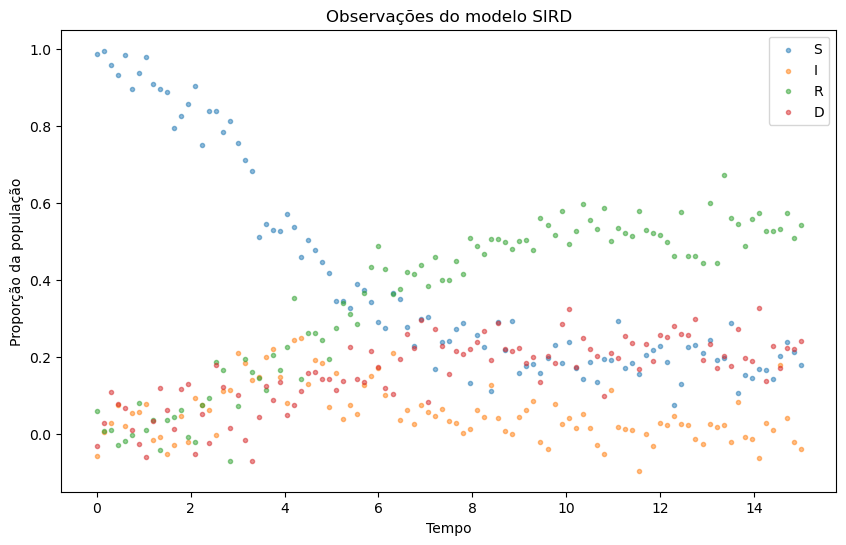

In [9]:
# Gerar dados sintéticos
np.random.seed(19920908)
Y0 = np.concatenate([np.array([0.97, 0.01, 0.0, 0.0]), np.zeros(12)])  # 4 estados + 4*3 sensitividades
t_span = (0, 15)
t_eval = np.linspace(*t_span, 101)
true_theta, true_sigma, true_gamma = 2.0, 0.7, 0.3

sol = solve_ivp(
    lambda t, y: ODESYS(y, t, true_theta, true_sigma, true_gamma),
    t_span, Y0, t_eval=t_eval, method='RK45'
)

y_obs = sol.y[:4].T + np.random.normal(0, 0.05, size=sol.y[:4].T.shape)
# Plot observações
plt.figure(figsize=(10, 6))
plt.scatter(t_eval, y_obs[:, 0], marker=".", alpha=0.5, label="S")
plt.scatter(t_eval, y_obs[:, 1], marker=".", alpha=0.5, label="I")
plt.scatter(t_eval, y_obs[:, 2], marker=".", alpha=0.5, label="R")
plt.scatter(t_eval, y_obs[:, 3], marker=".", alpha=0.5, label="D")
plt.legend()
plt.title("Observações do modelo SIRD")
plt.xlabel("Tempo")
plt.ylabel("Proporção da população")
plt.show()



In [10]:
# Gradiente descendente com busca linear
theta, sigma, gamma = 1.5, 1.0, 0.1  # Chute inicial
print(f"Valores verdadeiros: θ={true_theta:.4f}, σ={true_sigma:.4f}, gamma={true_gamma:.4f}")
print(f"Chute inicial:       θ={theta:.4f}, σ={sigma:.4f}, gamma={gamma:.4f}")
print("="*60)

cost = Cost(y_obs)
grad_c = autograd.grad(cost)

maxiter = 100
prev_cost = 1
tolerance = 1e-8
error_history = []
par_history = []

def line_search(theta, sigma, gamma, grad, sensitivities, Y, current_cost):
    alpha = 1.0
    beta = 0.2
    c = 1e-4
    new_cost = 2*current_cost

    s = c / np.linalg.norm(grad(Y))**2
    new_sensitivities = sensitivities

    while (new_cost > current_cost) and (s > 1e-10):
        s *= beta

        new_theta = theta - s * (grad(Y) * new_sensitivities[:, :, 0]).sum()
        new_sigma = sigma - s * (grad(Y) * new_sensitivities[:, :, 1]).sum()
        new_gamma = gamma - s * (grad(Y) * new_sensitivities[:, :, 2]).sum()

        sol = solve_ivp(
            lambda t, y: ODESYS(y, t, new_theta, new_sigma, new_gamma),
            t_span, Y0, t_eval=t_eval, method='RK45'
        )

        Y_new = sol.y[:4].T
        new_cost = cost(Y_new)
        new_sensitivities = sol.y[4:].T.reshape(-1, 4, 3)

    # Interpolação quadrática
    new_new_theta = new_theta - s * (grad(Y_new) * new_sensitivities[:, :, 0]).sum()
    new_new_sigma = new_sigma - s * (grad(Y_new) * new_sensitivities[:, :, 1]).sum()
    new_new_gamma = new_gamma - s * (grad(Y_new) * new_sensitivities[:, :, 2]).sum()

    sol = solve_ivp(
        lambda t, y: ODESYS(y, t, new_new_theta, new_new_sigma, new_new_gamma),
        t_span, Y0, t_eval=t_eval, method='RK45'
    )
    Y_new_new = sol.y[:4].T
    new_new_cost = cost(Y_new_new)

    div1 = (new_cost - current_cost) / s
    div2 = (new_new_cost - 2*new_cost + current_cost)/(2*s*s)
    alpha = 0.5 * (s - div1/div2)
    
    if alpha < 0:
        print(f"Erro: alpha={alpha:.4f}, s={s:.4f}")
        alpha = s

    return alpha

# Loop de otimização
for i in range(maxiter):
    sol = solve_ivp(
        lambda t, y: ODESYS(y, t, theta, sigma, gamma),
        t_span, Y0, t_eval=t_eval, method='RK45'
    )
    Y = sol.y[:4].T

    sensitivities = sol.y[4:].T.reshape(-1, 4, 3)

    current_cost = cost(Y)

    error_history.append(current_cost)
    par_history.append((theta, sigma, gamma))

    if abs((current_cost - prev_cost)/prev_cost) < tolerance and i > 0:
        print(f"Convergiu na iteração {i}")
        break

    prev_cost = current_cost

    alpha = line_search(theta, sigma, gamma, grad_c, sensitivities, Y, current_cost)

    theta -= alpha * (grad_c(Y) * sensitivities[:, :, 0]).sum()
    sigma -= alpha * (grad_c(Y) * sensitivities[:, :, 1]).sum()
    gamma -= alpha * (grad_c(Y) * sensitivities[:, :, 2]).sum()

    if i % 5 == 0:
        print(f"Iter {i}: theta={theta:.4f}, sigma={sigma:.4f}, gamma={gamma:.4f}, alpha={alpha:.4f}, cost={current_cost:.4f}")

Valores verdadeiros: θ=2.0000, σ=0.7000, gamma=0.3000
Chute inicial:       θ=1.5000, σ=1.0000, gamma=0.1000
Iter 0: theta=1.7369, sigma=0.7495, gamma=-0.1480, alpha=33.6263, cost=0.0039
Erro: alpha=-53.2151, s=20.6060
Erro: alpha=-40.8514, s=20.6060
Erro: alpha=-29.1149, s=20.6060
Erro: alpha=-18.3045, s=20.6060
Iter 5: theta=1.6449, sigma=1.0358, gamma=0.7951, alpha=20.6060, cost=0.0066
Erro: alpha=-9.0622, s=20.6060
Erro: alpha=-2.8262, s=20.6060
Erro: alpha=-3.8284, s=20.6060
Erro: alpha=-135.8137, s=20.6060
Iter 10: theta=2.0769, sigma=0.6142, gamma=0.3267, alpha=32.3612, cost=0.0034
Iter 15: theta=2.0344, sigma=0.7069, gamma=0.3194, alpha=7.6549, cost=0.0009
Iter 20: theta=2.0217, sigma=0.7019, gamma=0.3165, alpha=8.1437, cost=0.0009
Iter 25: theta=2.0122, sigma=0.6979, gamma=0.3142, alpha=7.6646, cost=0.0009
Iter 30: theta=2.0112, sigma=0.6970, gamma=0.3140, alpha=102.9837, cost=0.0009
Erro: alpha=-22196.2285, s=20.6060
Iter 35: theta=2.0105, sigma=0.6968, gamma=0.3139, alpha=20.

In [11]:
print("\n" + "-" * 80)
print("RESULTADOS FINAIS:")
print(f"Valores verdadeiros: θ={true_theta:.4f}, σ={true_sigma:.4f}, gamma={true_gamma:.4f}")
print(f"Valores estimados:   θ={theta:.4f}, σ={sigma:.4f}, gamma={gamma:.4f}")
print(f"Erro θ: {abs(theta - true_theta)/true_theta*100:.2f}%")
print(f"Erro σ: {abs(sigma - true_sigma)/true_sigma*100:.2f}%")
print(f"Erro gamma: {abs(gamma - true_gamma)/true_gamma*100:.2f}%")
print(f"Custo final: {current_cost:.6f}")


--------------------------------------------------------------------------------
RESULTADOS FINAIS:
Valores verdadeiros: θ=2.0000, σ=0.7000, gamma=0.3000
Valores estimados:   θ=2.0096, σ=0.6964, gamma=0.3137
Erro θ: 0.48%
Erro σ: 0.51%
Erro gamma: 4.56%
Custo final: 0.000944


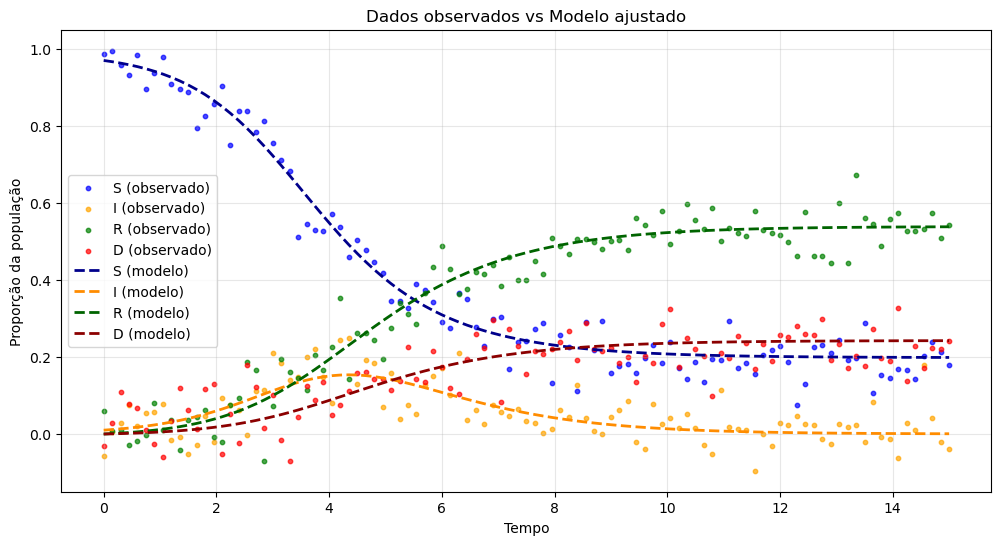

In [12]:
# Plot comparação entre dados observados e modelo ajustado
sol_final = solve_ivp(
    lambda t, y: ODESYS(y, t, theta, sigma, gamma),
    t_span, Y0, t_eval=t_eval, method='RK45'
)
y_final = sol_final.y[:4].T

plt.figure(figsize=(12, 6))

plt.scatter(t_eval, y_obs[:, 0], alpha=0.7, label='S (observado)', color='blue', s=10)
plt.scatter(t_eval, y_obs[:, 1], alpha=0.7, label='I (observado)', color='orange', s=10)
plt.scatter(t_eval, y_obs[:, 2], alpha=0.7, label='R (observado)', color='green', s=10)
plt.scatter(t_eval, y_obs[:, 3], alpha=0.7, label='D (observado)', color='red', s=10)

plt.plot(t_eval, y_final[:, 0], '--', label='S (modelo)', color='darkblue', linewidth=2)
plt.plot(t_eval, y_final[:, 1], '--', label='I (modelo)', color='darkorange', linewidth=2)
plt.plot(t_eval, y_final[:, 2], '--', label='R (modelo)', color='darkgreen', linewidth=2)
plt.plot(t_eval, y_final[:, 3], '--', label='D (modelo)', color='darkred', linewidth=2)

plt.xlabel('Tempo')
plt.ylabel('Proporção da população')
plt.title('Dados observados vs Modelo ajustado')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


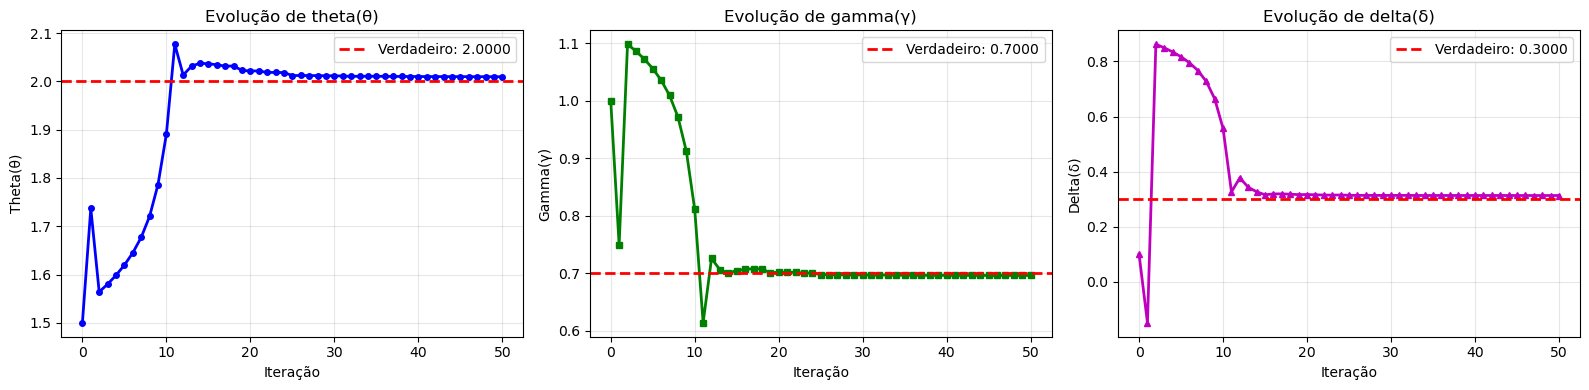

In [13]:
# Plot da evolução dos parâmetros durante a otimização
par_history = np.array(par_history)

plt.figure(figsize=(16, 4))

# Subplot 1: theta
plt.subplot(1, 3, 1)
plt.plot(par_history[:, 0], 'b-', linewidth=2, marker='o', markersize=4)
plt.axhline(y=true_theta, color='r', linestyle='--', linewidth=2, label=f'Verdadeiro: {true_theta:.4f}')
plt.xlabel('Iteração')
plt.ylabel('Theta(θ)')
plt.title('Evolução de theta(θ)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: sigma
plt.subplot(1, 3, 2)
plt.plot(par_history[:, 1], 'g-', linewidth=2, marker='s', markersize=4)
plt.axhline(y=true_sigma, color='r', linestyle='--', linewidth=2, label=f'Verdadeiro: {true_sigma:.4f}')
plt.xlabel('Iteração')
plt.ylabel('Gamma(γ)')
plt.title('Evolução de gamma(γ)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: gamma
plt.subplot(1, 3, 3)
plt.plot(par_history[:, 2], 'm-', linewidth=2, marker='^', markersize=4)
plt.axhline(y=true_gamma, color='r', linestyle='--', linewidth=2, label=f'Verdadeiro: {true_gamma:.4f}')
plt.xlabel('Iteração')
plt.ylabel('Delta(δ)')
plt.title('Evolução de delta(δ)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Estimated: theta=2.0096, sigma=0.6964, gamma=0.3137
True: theta=2.0000, sigma=0.7000, gamma=0.3000


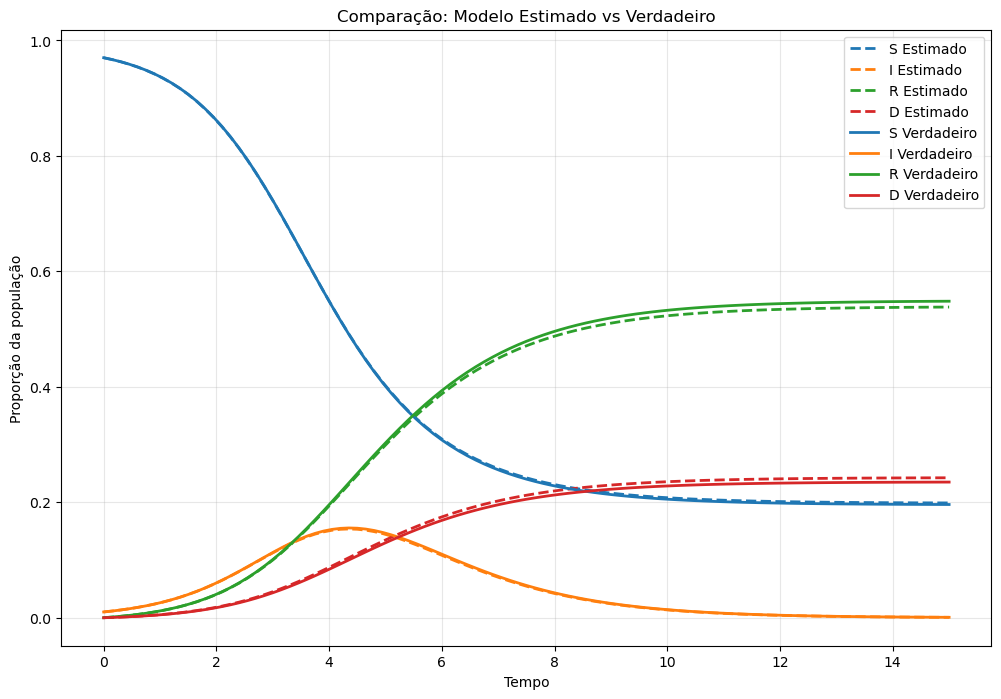

In [14]:
# Comparação das soluções
print(f"Estimated: theta={theta:.4f}, sigma={sigma:.4f}, gamma={gamma:.4f}")
print(f"True: theta={true_theta:.4f}, sigma={true_sigma:.4f}, gamma={true_gamma:.4f}")

sol_est = solve_ivp(
    lambda t, y: ODESYS(y, t, theta, sigma, gamma),
    t_span, Y0, t_eval=t_eval
)
sol_true = solve_ivp(
    lambda t, y: ODESYS(y, t, true_theta, true_sigma, true_gamma),
    t_span, Y0, t_eval=t_eval
)

plt.figure(figsize=(12, 8))

plt.plot(t_eval, sol_est.y[0], '--', label='S Estimado', color='C0', linewidth=2)
plt.plot(t_eval, sol_est.y[1], '--', label='I Estimado', color='C1', linewidth=2)
plt.plot(t_eval, sol_est.y[2], '--', label='R Estimado', color='C2', linewidth=2)
plt.plot(t_eval, sol_est.y[3], '--', label='D Estimado', color='C3', linewidth=2)

plt.plot(t_eval, sol_true.y[0], label='S Verdadeiro', color='C0', linewidth=2)
plt.plot(t_eval, sol_true.y[1], label='I Verdadeiro', color='C1', linewidth=2)
plt.plot(t_eval, sol_true.y[2], label='R Verdadeiro', color='C2', linewidth=2)
plt.plot(t_eval, sol_true.y[3], label='D Verdadeiro', color='C3', linewidth=2)

plt.xlabel('Tempo')
plt.ylabel('Proporção da população')
plt.title('Comparação: Modelo Estimado vs Verdadeiro')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()